In [1]:
%matplotlib inline
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib
import arviz as az
import theano
import ODE_models
import ODE_models_forls
import pandas as pd
import scipy.integrate as integrate
from scipy.integrate import quad
plt.style.use('seaborn-darkgrid')

In [2]:
r_newyorkTSV = '../../newyork.tsv'
w_newyorkTSV = '../../newyork.tsv'
tsv_readny = pd.read_csv("newyork.tsv", sep='\t')
confirmed_rolling = tsv_readny['confirmed_rolling']

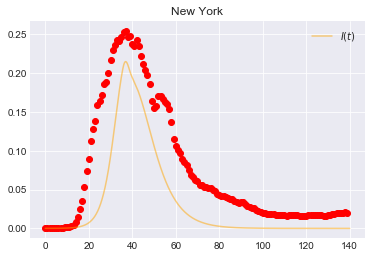

In [15]:

params = ODE_models.get_params(beta_S = 0.7,beta_A= 9.83891758e-01,gamma = 1/7,q= 8.17463977e-02, nu = 6.41629346e-01, m = 1.69363348e+01, rho= 7.18632753e+01, dealthdelt = 0.02, xi = 1/3, p =2/3)
## Set initial conditions
Nny= .002*19.4e6
yobsny = confirmed_rolling/Nny
Sn_0ny  = 1-(0.005+yobsny[0])
Sa_0  = 0.005
IS_0ny  = yobsny[0]

#Sa_0  =  2.49220975e-01
#IS_0ny  = 1.00000000e-10
#Sn_0ny = 1-(Sa_0+IS_0ny)
En_0 = 0
Ea_0 = 0
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0.01

#newyork
initial_stateny = np.array([Sn_0ny,Sa_0,En_0, Ea_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
timeny = np.arange(0,140,.001)
timeobsny = np.arange(0,140,1)
sim_systemny = odeint(ODE_models.SEIRan_system, initial_stateny, timeny, args=(params,))



yny =sim_systemny[:,4]

ypred = np.zeros(140)
for i in range(0,140):
    ind = np.where(timeny ==i)
    ypred[i] = yny[ind]


plt.plot(timeobsny,yobsny, color= 'red',marker='o', linestyle='none')
plt.plot(timeny, yny, color='orange', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.title('New York')
plt.show()

In [4]:
#This is where the least squares is claculated for New York
def SEfunc(params):
    #SEfunc is a function that takes the parameters of the ODE models as an input and outputs the least squares value for the function at that time
    #What I need is a fucntion that computes the least squares at the starting points for the values? I.e. if the function
    #remained at those initial guesses
    beta_A = params[0]
    q= params[1]
    nu=params[2]
    m = params[3]
    rho = params[4]
    Sa_0 = params[5]
    IS_0ny= params[6]
    yobsny = np.array(confirmed_rolling/Nny)
    Sn_0ny = 1-(Sa_0+IS_0ny)
    En_0 = 0
    Ea_0 = 0
    IAn_0 = 0
    IAa_0 = 0
    RS_0  = 0
    RAn_0 = 0
    RAa_0 = 0
    M_0   = 0.01
    
    
    se_params = ODE_models_forls.get_params(beta_A= beta_A, q = q,nu = nu, m=m,rho=rho)

   
    initial_stateny = np.array([Sn_0ny,Sa_0,En_0, Ea_0,IS_0ny,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
    timeny = np.arange(0,140,.001)
    timeobsny = np.arange(0,140,1)
    sim_systemny = odeint(ODE_models_forls.SEIRan_system, initial_stateny, timeny, args=(se_params,))
    yny =sim_systemny[:,4]
    
    ypred = np.zeros(140)
    for i in range(0,140):
        ind = np.where(timeny ==i)
        ypred[i] = yny[ind]
    
    SE = (ypred-yobsny)**2
    sumSE = sum(SE)
    return(sumSE)

In [5]:
import random as random
sims = int(1e2)
values = np.zeros((8,sims))
for i in range(0,sims):
    starting_points = np.zeros(7) #beta_a, q, nu, m, rho, S-a(0), I_s(0)
    starting_points[0] = np.random.uniform(0,1)
    starting_points[1] = np.random.uniform(0,1)
    starting_points[2] = np.random.uniform(0,1)
    starting_points[3] = np.random.uniform(10,100)
    starting_points[4] = np.random.uniform(0,100)
    starting_points[5] = np.random.uniform(0,1)
    starting_points[6] = np.random.uniform(0,1)
    least_sq = SEfunc(starting_points)
    values[0:6,i] = starting_points[0:6]
    values[7,i] = least_sq
    

/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [11]:
least = list(values[7])
x=min(least)
minimum = least.index(x)
print(minimum)
print(values[:,minimum])
x0_ = values[:,minimum]

71
[ 0.98389176  0.0817464   0.64162935 16.9363348  71.86327529  0.24922097
  0.          0.81927952]


In [12]:
x0=x0_[:7]

result= optimization.least_squares(SEfunc, x0,bounds=(np.array([0,0,0,10,0,0,0]),np.array([1,1,1,100,100,1,1])))

In [13]:
print(result)

 active_mask: array([ 0,  0,  0,  0,  0,  0, -1])
        cost: 1.4141659631690422
         fun: array([1.68176453])
        grad: array([-3.09558673e-02, -2.01752509e-03,  2.67608375e-01,  1.01371789e-02,
       -2.67516690e-03, -1.15083559e-01,  5.43367333e+06])
         jac: array([[-1.84067786e-02, -1.19964778e-03,  1.59123570e-01,
         6.02770408e-03, -1.59069053e-03, -6.84302449e-02,
         3.23093587e+06]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 12
        njev: 1
  optimality: 0.1717053867504875
      status: 3
     success: True
           x: array([9.83891758e-01, 8.17463977e-02, 6.41629346e-01, 1.69363348e+01,
       7.18632753e+01, 2.49220975e-01, 1.00000000e-10])
